## Import modules

In [6]:
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/ubuntu data/kaggle.json" ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:27<00:00, 39.7MB/s]
100% 1.04G/1.04G [00:27<00:00, 40.1MB/s]


In [10]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm ## progresbar
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, add

In [11]:
BASE_DIR="/content/kaggle/input/flickr8k"
os.makedirs(BASE_DIR, exist_ok=True)
WORKING_DIR="/content/kaggle/working"
os.makedirs(WORKING_DIR, exist_ok=True)

In [12]:
!unzip flickr8k.zip -d /content/kaggle/input/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/input/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/kaggle/input/flickr8k/Images/2848266893_9693c66275.jpg  
 

## EXTRACT IMAGE FEATURES

In [13]:
#load model
MODEL=VGG16()
#restructure the model
model=Model(inputs=MODEL.inputs, outputs=MODEL.layers[-2].output)
# here we are using vgg16 model and take all of its layers except last layer
print(model.summary())

553467096/553467096 [==============================] - 13s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [14]:
## Extract features from image
features={}
directory=os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):  ## tqdm indicate progressbar
  img_path=directory+"/"+img_name
  image=load_img(img_path,target_size=(224,224))
  image=img_to_array(image)
  #rgb image have 3 dimensions
  image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  #preprocess image for VGG
  image=preprocess_input(image)
  #extract feature
  feature=model.predict(image,verbose=0)
  #get image id
  image_id=img_name.split('.')[0]
  #store feature
  features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [15]:
#store feature in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [16]:
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
  features=pickle.load(f)

## load captions data


In [75]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
  next(f)
  captions_doc=f.read()

In [76]:
##mapting cation to image
mapping={}
for line in tqdm(captions_doc.split('\n')):
  tokens=line.split(',')
  if len(tokens) < 2:
    continue
  image_id, caption=tokens[0], tokens[1:]
  image_id=image_id.split('.')[0]
  caption==" ".join(caption)   ## list with join
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [77]:
mapping['2097407245_c798e0dcaf']

[['A man in a winter jacket and knit cap stand with his arms up at his side in a snow landscape .'],
 ['A man is standing on dirt with his hands in the air with mountains and snow behind him .'],
 ['A man raises his arms on rocky beach .'],
 ['One lone man with fist in the air with large rocky mountains in the background'],
 ['Man with outstretched arms standing on snow-covered rocks .']]

In [78]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption=captions[i][0]
      caption.lower().replace('[^A-Za-z]','') #remove everything except alphabets
      caption=caption.replace('\s+',' ') #replace multiple space with single space
      caption="startseq "+ " ".join([word for word in caption.split() if len(word) > 1]) +" endseq"  ## done for model and remove single characters
      captions[i]=caption

In [79]:
clean(mapping)

In [80]:
mapping['2097407245_c798e0dcaf']

['startseq man in winter jacket and knit cap stand with his arms up at his side in snow landscape endseq',
 'startseq man is standing on dirt with his hands in the air with mountains and snow behind him endseq',
 'startseq man raises his arms on rocky beach endseq',
 'startseq One lone man with fist in the air with large rocky mountains in the background endseq',
 'startseq Man with outstretched arms standing on snow-covered rocks endseq']

In [81]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [82]:
len(all_captions)

40455

In [83]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq Two dogs of different breeds looking at each other on the road endseq',
 'startseq Two dogs on pavement moving toward each other endseq']

In [84]:
### tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1


In [85]:
max_length=max(len(caption.split()) for caption in all_captions)
## finding max length for padding
print(max_length)

31


## train test split

In [86]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*90)
train=image_ids[:split]
test=image_ids[split:]

In [87]:
print(features['2192333873_2a0cbe849d'][0])

[0.19109327 0.         3.2120185  ... 0.         2.5010936  0.30804375]


## To prevent session crashing use batch size image data generator to fetch data in batch


In [88]:
def data_generator(data_keys, mapping, features,tokeizer,max_length, vocab_size,batch_size):
  X1,X2,y=list(),list(),list()
  n=0

  while 1:
    for key in data_keys:
      n+=1
      captions=mapping[key]
      for caption in captions:
        seq=tokenizer.texts_to_sequences([caption])[0]
        # doing n-gram on seq
        # a b c d e
        # a -> b, a b ->c, a b c -> d
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i],seq[i]
          #padding
          in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
          # encode output like one hot encoding
          # use 0 bcz we get lists
          out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n==batch_size:
        X1,X2,y=np.array(X1),np.array(X2),np.array(y)
        yield [X1,X2], y
        X1,X2,y=list(),list(),list()
        n=0


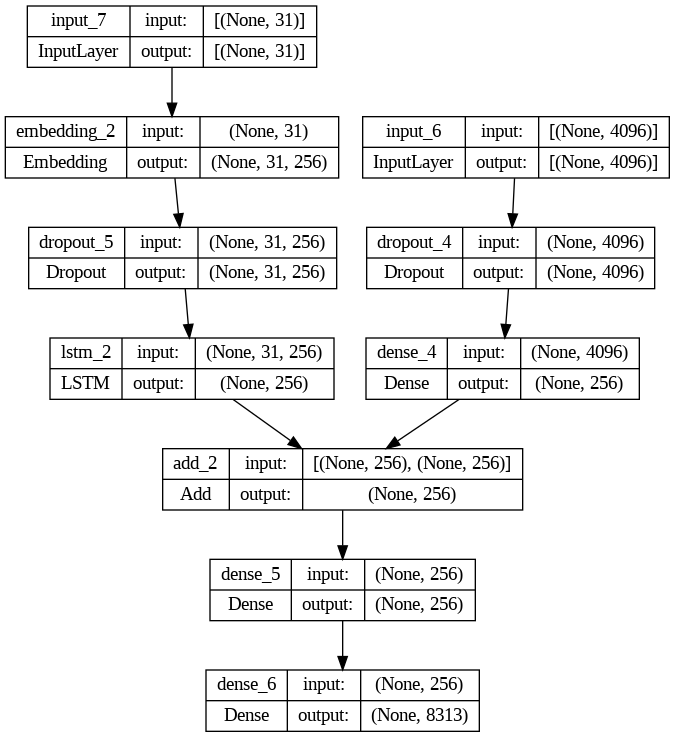

In [89]:
## fc2 (Dense)                 (None, 4096)              16781312

##encoder model

##image feature layers
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
##seq feature layers
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)


#decoder mdoel'
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size, activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

##plotting model
plot_model(model,show_shapes=True)

In [135]:
 ## train the model
epochs=1
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
  generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
  ## for each epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps,verbose=1)

252/252 [==============================] - 76s 300ms/step - loss: 2.4454


## Generate caption for image && save model

In [95]:
tokenizer.index_word

{1: 'startseq',
 2: 'endseq',
 3: 'in',
 4: 'the',
 5: 'on',
 6: 'is',
 7: 'and',
 8: 'dog',
 9: 'with',
 10: 'man',
 11: 'of',
 12: 'two',
 13: 'white',
 14: 'black',
 15: 'boy',
 16: 'are',
 17: 'woman',
 18: 'girl',
 19: 'to',
 20: 'wearing',
 21: 'people',
 22: 'at',
 23: 'water',
 24: 'young',
 25: 'red',
 26: 'brown',
 27: 'an',
 28: 'his',
 29: 'blue',
 30: 'dogs',
 31: 'running',
 32: 'through',
 33: 'playing',
 34: 'shirt',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'standing',
 39: 'ball',
 40: 'grass',
 41: 'person',
 42: 'child',
 43: 'snow',
 44: 'jumping',
 45: 'over',
 46: 'three',
 47: 'front',
 48: 'sitting',
 49: 'small',
 50: 'up',
 51: 'a',
 52: 'field',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [96]:
def idx_to_word(integer, tokenizer):
    try:
        return tokenizer.index_word[integer]
    except KeyError:
        return None


In [97]:
a=tokenizer.texts_to_sequences(["girl with painting"])[0]
pad_sequences([a],max_length)[0], a

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  18,   9, 749], dtype=int32),
 [18, 9, 749])

In [98]:
def predict(model, image, tokenizer, max_length):
  intext='startseq'
  for i in range(max_length):
    sequence=tokenizer.texts_to_sequences([intext])[0]
    sequence=pad_sequences([sequence],max_length) ## no need to take [0]
    yhat=model.predict([image, sequence],verbose=0)
    yhat=np.argmax(yhat)
    word=idx_to_word(yhat,tokenizer)
    if word is None:
      break
    intext+=" "+ word
    if word=="endseq":
      break
  return intext


In [99]:
actual,predicted= list(),list()

for key in tqdm(test):
  captions=mapping[key]
  y_pred=predict(model,features[key],tokenizer, max_length)
  actual_captions=[caption.split() for caption in captions]
  y_pred=y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)

# from nltk.translate.bleu_score import corpus_bleu
# print("BLUE-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
# print("BLUE-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

0it [00:00, ?it/s]

In [136]:
from PIL import Image
import matplotlib.pyplot as plt
def fun(image_name):
  image=Image.open(os.path.join(BASE_DIR, "Images", image_name))
  image_id=image_name.split('.')[0]
  captions=mapping[image_id]
  print("________Actual__________")
  for caption in captions:
    print(caption)
  y_pred=predict(model,features[image_id],tokenizer, max_length)
  print("___________predicted___________")
  print(y_pred)
  plt.imshow(image)

In [137]:
l=os.listdir(os.path.join(BASE_DIR, "Images"))

________Actual__________
startseq biker makes high jump endseq
startseq man doing an aerial stunt on bike endseq
startseq man on bicycle performing jump endseq
startseq "A person on bicycle wears helmet and jumps endseq
startseq The cyclist is making high jump with his bike endseq
___________predicted___________
startseq man in red shirt is jumping uphill on dirt bike endseq


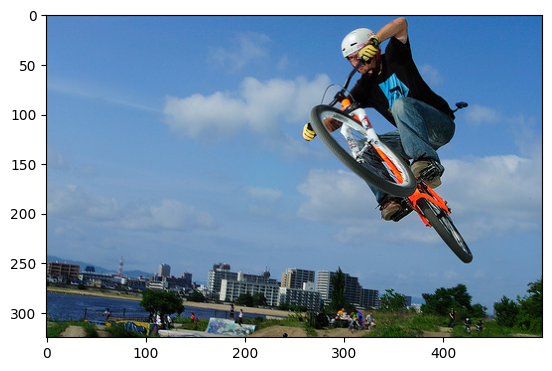

In [138]:
fun(l[10])

________Actual__________
startseq brown dog running through the woods endseq
startseq dog running through forest in the winter time endseq
startseq dog running through lot of twigs endseq
startseq lean dog runs through wooded area endseq
startseq weimaraner dog runs through the woods wearing red collar endseq
___________predicted___________
startseq dog jumps over tree endseq


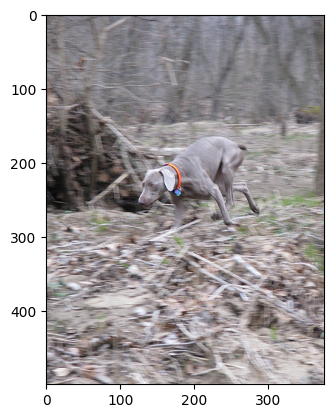

In [139]:
fun(l[23])

________Actual__________
startseq group of children carrying poles and swords endseq
startseq group of kids stand in row holding sticks and swords endseq
startseq "Children group together in front of crowd endseq
startseq Kids standing in line with family watching in the background endseq
startseq There is group of young children holding sticks while standing in the grass endseq
___________predicted___________
startseq children play with stuffed flags endseq


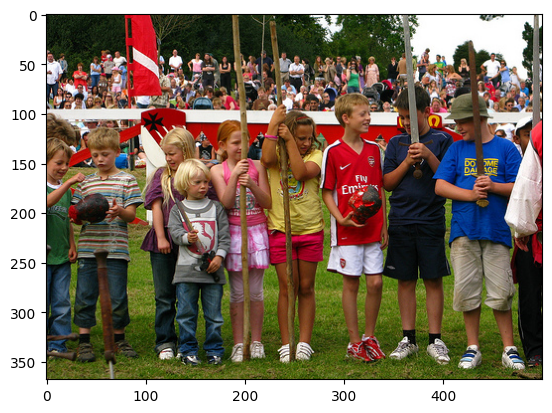

In [140]:
fun(l[49])